In [1]:
!pip install ta
import numpy as np
import gym
from gym import spaces
import pandas as pd
import random
import json
import ta




  Created wheel for ta: filename=ta-0.5.11-cp36-none-any.whl size=23029 sha256=7f27763b17606f1888061d480bb3bcbe4378928c2cb0e24ffb244167fa98a2fc
  Stored in directory: /root/.cache/pip/wheels/97/32/1d/cbc724a8ecaec6e426baf57ab8c4c2cdc687aadd7427280b1f
Successfully built ta


In [2]:
# get data from google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Preprocessing the data into a list of days with rolling VWAP and miliseconds 
#   from midnight.
# Notes:
#   The VWAP is calculated using the Closing price because of the 5min 
#   granularity of the data. More fine grain data is needed.

colnames=['Date', 'Time', 'Open','High', 'Low', 'Close', 'Volume'] 
data =  pd.read_csv('/content/gdrive/My Drive/TensorTrade_VWAP/ALSI5M.txt',
                    sep = ','  , names=colnames, header=None)
data[['Open','High', 'Low', 'Close', 'Vol']] = data[['Open','High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric)
# data.head()
# def calc_rolling_VWAP(in_data):
df = data.iloc[246132 : len(data[['Volume']]), ]
df['VbyC'] = df['Close']*df['Volume']
df['logged_and_diffed'] = (np.log(df['Close']) - np.log(df['Close'].shift(1)))*1000
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Date,Time,Open,High,Low,Close,Volume,Vol,VbyC,logged_and_diffed
246132,2009/09/17,08:34:53,23472,23650,23472,23650,41,41,969650,NaN
246133,2009/09/17,08:39:37,23650,23700,23649,23700,74,74,1753800,2.111933
246134,2009/09/17,08:44:12,23700,23700,23680,23680,54,54,1278720,-0.844238
246135,2009/09/17,08:49:53,23680,23727,23680,23727,19,19,450813,1.982830
246136,2009/09/17,08:54:40,23740,23745,23725,23725,47,47,1115075,-0.084296


In [4]:
# getting miliseconds from midniight column
def get_sec(time_str):
    """Get Seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)


df['Msec'] = df['Time'].apply(get_sec)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [5]:
# # !pip install ta
# import ta
# import pandas as pd


diff = lambda x, y: x - y
abs_diff = lambda x, y: abs(x - y)


indicators = [
  ('RSI', ta.momentum.rsi, ['Close']),
  ('MFI', ta.momentum.money_flow_index, ['High', 'Low', 'Close', 'Volume']),
  ('TSI', ta.momentum.tsi, ['Close']),
  ('UO', ta.momentum.uo, ['High', 'Low', 'Close']),
  ('AO', ta.momentum.ao, ['High', 'Close']),
  ('MACDDI', ta.trend.macd_diff, ['Close']),
  ('VIP', ta.trend.vortex_indicator_pos, ['High', 'Low', 'Close']),
  ('VIN', ta.trend.vortex_indicator_neg, ['High', 'Low', 'Close']),
  ('VIDIF', abs_diff, ['VIP', 'VIN']),
  ('TRIX', ta.trend.trix, ['Close']),
  ('MI', ta.trend.mass_index, ['High', 'Low']),
  ('CCI', ta.trend.cci, ['High', 'Low', 'Close']),
  ('DPO', ta.trend.dpo, ['Close']),
  ('KST', ta.trend.kst, ['Close']),
  ('KSTS', ta.trend.kst_sig, ['Close']),
  ('KSTDI', diff, ['KST', 'KSTS']),
  ('ARU', ta.trend.aroon_up, ['Close']),
  ('ARD', ta.trend.aroon_down, ['Close']),
  ('ARI', diff, ['ARU', 'ARD']),
  ('BBH', ta.volatility.bollinger_hband, ['Close']),
  ('BBL', ta.volatility.bollinger_lband, ['Close']),
  ('BBM', ta.volatility.bollinger_mavg, ['Close']),
  ('BBHI', ta.volatility.bollinger_hband_indicator, ['Close']),
  ('BBLI', ta.volatility.bollinger_lband_indicator, ['Close']),
  ('KCHI', ta.volatility.keltner_channel_hband_indicator, ['High', 'Low', 'Close']),
  ('KCLI', ta.volatility.keltner_channel_lband_indicator, ['High', 'Low', 'Close']),
  ('DCHI', ta.volatility.donchian_channel_hband_indicator, ['Close']),
  ('DCLI', ta.volatility.donchian_channel_lband_indicator, ['Close']),
  ('ADI', ta.volume.acc_dist_index, ['High', 'Low', 'Close', 'Volume']),
  ('OBV', ta.volume.on_balance_volume, ['Close', 'Volume']),
  ('CMF', ta.volume.chaikin_money_flow, ['High', 'Low', 'Close', 'Volume']),
  ('FI', ta.volume.force_index, ['Close', 'Volume']),
  ('EM', ta.volume.ease_of_movement, ['High', 'Low', 'Close', 'Volume']),
  ('VPT', ta.volume.volume_price_trend, ['Close', 'Volume']),
  ('NVI', ta.volume.negative_volume_index, ['Close', 'Volume']),
  ('DR', ta.others.daily_return, ['Close']),
  ('DLR', ta.others.daily_log_return, ['Close'])
  ]


def add_indicators(df) -> pd.DataFrame:
    for name, f, arg_names in indicators:
        wrapper = lambda func, args: func(*args)
        args = [df[arg_name] for arg_name in arg_names]
        df[name] = wrapper(f, args)
    df.fillna(method='bfill', inplace=True)
    return df


# Here we add all of th indicators and two all zero columns to later be used
#  for A_VWAP, and A_vol_left:
df = add_indicators(df)
df['zzz_A_VWAP'] = 0
df['zzz_A_vol_left'] = 0



#.reset_index())
# df = dataframes[1]

# df['logged_and_diffed'] = np.log(df['Close']) - np.log(df['Close'].shift(1))
# # ##len(dataframes)
# # ##checking that VWAP calculations are correct with a plot
# day = -2
# import matplotlib.pyplot as plt 
# a = df['logged_and_diffed']
# b = df['Close']
# x = range(len(b))
# # plotting the points 
# plt.subplot(1, 2, 1) 
# plt.plot(x, b) 
# plt.subplot(1, 2, 2)
# plt.plot(x,a)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [0]:
# a = np.array([df.iloc[4]])
# len(df.iloc[4])
# a[:,-2] = 420.69
# a

In [0]:
# ======== GROUPING DAYS ==========
grouped = df.groupby('Date')
dataframes = [group for _, group in grouped]


In [0]:
# Rolling vwap
def calc_rolling_vwap(data_frame):
  data = np.cumsum(data_frame[['Vol']]) 
  data['rolling_VbyC'] = np.cumsum(data_frame[['VbyC']])
  # = rolling_VbyC.div( rolling_volume,axis = 0)
  #return VWAP
  return round(data['rolling_VbyC']/data['Vol'])

for i in range(len(dataframes)):
  dataframes[i]['VWAP'] = calc_rolling_vwap(dataframes[i])
  dataframes[i]['VWAP_Close_Diff'] = dataframes[i]['VWAP'] - dataframes[i]['Close']
  dataframes[i] = dataframes[i].loc[:, dataframes[i].columns != 'Date']
  dataframes[i] = dataframes[i].loc[:, dataframes[i].columns != 'Time']



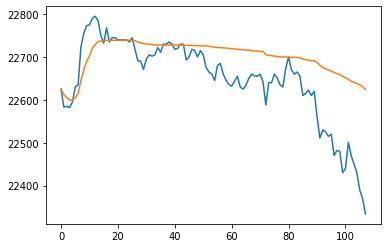

In [9]:
# ##len(dataframes)
# ##checking that VWAP calculations are correct with a plot
day = 9
import matplotlib.pyplot as plt 
a = dataframes[day]['VWAP']
b = dataframes[day]['Close']
x = range(len(b))
# plotting the points  
plt.plot(x, b) 
plt.plot(x,a)

In [10]:
# take out the first and last trading days

dataframes.pop()
dataframes.pop(0)


,Open,High,Low,Close,Volume,Vol,VbyC,logged_and_diffed,Msec,RSI,MFI,TSI,UO,AO,MACDDI,VIP,VIN,VIDIF,TRIX,MI,CCI,DPO,KST,KSTS,KSTDI,ARU,ARD,ARI,BBH,BBL,BBM,BBHI,BBLI,KCHI,KCLI,DCHI,DCLI,ADI,OBV,CMF,FI,EM,VPT,NVI,DR,DLR,zzz_A_VWAP,zzz_A_vol_left,VWAP,VWAP_Close_Diff
246132,23472,23650,23472,23650,41,41,969650,2.111933,30893,100.000000,32.131314,100.000000,37.382263,0.000000,9.726621,0.035849,0.040725,0.004876,0.006616,0.000000,66.666667,14485.847720,-379.848583,-379.848583,0.000000,4.0,4.0,0.0,23650.000000,23650.000000,23650.000000,0.0,0.0,0.0,0.0,1.0,1.0,41.000000,41,1.000000,-3577.469962,2.442405e+07,-15.578500,1000.000000,-37.984858,0.211193,0,0,23650.0,0.0
246133,23650,23700,23649,23700,74,74,1753800,2.111933,31177,100.000000,32.131314,100.000000,37.382263,0.000000,9.726621,0.035849,0.040725,0.004876,0.006616,0.000000,66.666667,14460.847720,-379.193032,-379.520807,0.327776,8.0,4.0,4.0,23725.000000,23625.000000,23675.000000,0.0,0.0,0.0,0.0,1.0,0.0,115.000000,115,1.000000,-3577.469962,2.442405e+07,-15.417344,1000.000000,0.211416,0.211193,0,0,23682.0,-18.0
246134,23700,23700,23680,23680,54,54,1278720,-0.844238,31452,69.892473,32.131314,99.115044,37.382263,0.000000,9.726621,0.035849,0.040725,0.004876,0.006616,0.000000,52.920354,14459.181054,-379.149328,-379.396981,0.247653,8.0,4.0,4.0,23717.762760,23635.570573,23676.666667,0.0,0.0,0.0,0.0,0.0,0.0,61.000000,61,0.360947,-3577.469962,1.309122e+06,0.110879,999.156118,-0.084388,-0.084424,0,0,23681.0,1.0
246135,23680,23727,23680,23727,19,19,450813,1.982830,31793,82.912403,32.131314,98.415326,37.382263,0.000000,9.726621,0.035849,0.040725,0.004876,0.006616,0.000000,74.937073,14446.597720,-378.819368,-379.252578,0.433210,16.0,4.0,12.0,23745.523884,23632.976116,23689.250000,0.0,0.0,0.0,0.0,1.0,0.0,80.000000,80,0.425532,-3577.469962,2.674169e+06,-0.007858,1001.139241,0.198480,0.198283,0,0,23686.0,-41.0
246136,23740,23745,23725,23725,47,47,1115075,-0.084296,32080,81.301210,32.131314,97.760186,37.382263,0.000000,9.726621,0.035849,0.040725,0.004876,0.006616,0.000000,94.444444,14439.447720,-378.631880,-379.128438,0.496558,16.0,4.0,12.0,23754.290932,23638.509068,23696.400000,0.0,0.0,0.0,0.0,0.0,0.0,33.000000,33,0.140426,-3577.469962,2.655427e+06,0.033749,1001.139241,-0.008429,-0.008430,0,0,23694.0,-31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246235,23720,23720,23670,23700,136,136,3223200,-0.843526,61768,46.920650,42.408031,3.701498,49.513649,20.617647,-0.935754,0.930451,1.107143,0.176692,0.003211,25.643128,-55.525114,32.950000,0.946507,0.418358,0.528149,84.0,12.0,72.0,23772.311107,23661.788893,23717.050000,0.0,0.0,0.0,0.0,0.0,0.0,-1174.296097,83,0.007149,-1480.356196,-6.012658e+06,-0.085997,1005.107163,-0.084317,-0.084353,0,0,23697.0,-3.0
246236,23700,23720,23700,23715,117,117,2774655,0.632711,62095,49.911664,37.500746,3.135582,49.741521,11.617647,-1.404642,0.923237,1.159751,0.236515,0.003119,25.563934,-21.889803,0.500000,0.927650,0.565291,0.362359,80.0,8.0,72.0,23769.593912,23669.406088,23719.500000,0.0,0.0,0.0,0.0,0.0,0.0,-1115.796097,200,0.031506,-1018.162454,1.265022e+06,-0.040621,1005.743306,0.063291,0.063271,0,0,23697.0,-18.0
246237,23710,23750,23710,23744,213,213,5057472,1.222108,62368,55.171135,42.384687,4.253808,53.375001,7.370588,0.175708,0.975359,0.993840,0.018480,0.003205,25.536145,42.663477,-20.750000,1.071636,0.710116,0.361520,76.0,4.0,72.0,23771.966696,23669.533304,23720.750000,0.0,0.0,0.0,0.0,0.0,0.0,-966.696097,413,0.025830,9.717897,3.369272e+06,0.334519,1005.743306,0.122285,0.122211,0,0,23697.0,-47.0
246238,23740,23800,23740,23784,245,245,5827080,1.683219,62694,61.219832,43.085506,7.240260,55.038668,17.300000,3.659229,1.003824,0.908222,0.095602,0.003730,25.630360,145.036331,-40.950000,1.316203,0.851859,0.464344,100.0,12.0,88.0,23780.566756,23671.333244,23725.950000,1.0,1.0,1.0,0.0,1.0,0.0,-852.362764,658,0.072703,14

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [0]:
# =============================== MARKET Class ===============================
# 
# MNH 2019
#
# This class must take in a list of dataframes.
# 
# Each dataframe in the list is one trading day.
# Each trading day is completely fresh and they are sampled at random everytime
#   the environment is reset. (So that each episode of training is done on a 
#   unique day).
# 
# The agent recieves Reward r only at the end of the trading day.
# The Reward r is calculated as difference between the trading days VWAP, and 
#    the agents personal VWAP named A_VWAP.
#
# A possible alternative to explore using is a rolling sortino ratio, or just a
#   rolling A_VWAP.
#
# --------------------- How the functions should work: --------------------
#
# 1.) env.reset():                                    Exmpl Values:
# -----------------                                   ---------------------
#   
#   * Reseting the environment randomly selects a
#       day from list_of_df, and resets the variables:
#       reward, ind_in_day, A_VWAP, etc..
#       
#
# 2.)   env.step():                                   Exmpl Values:
# -----------------                                   ---------------------
#
#   * Keep track of period within the day.            ind_in_day += 1
# 
#   * Take an Action a in the market.
#
#   * The action space is made up of N discrete 
#         choices.                                    a = 4    
#
#   * The agent buys volume a * trade_size at a price 
#         randomly sampled from the 5 min     
#         interval from :  [Lowest_prc, HIghest_prc]                                      
#
#   * Keep track of the agents volume of trades.      A_Vol= 0 + a * trade_size
#
#   * Keep track of how many shares the agent still 
#         needs to buy.                               A_trgt_vol = 1000 - A_Vol
#
#   * Keep track of the agents rolling VWAP: A_VWAP,
#         calculated as:
#                cumsum(purchs price * purchs vol)    A_VWAP = 0
#   
#   * Return the tuple: (state2=s2, reward=r, done)
# 
#   * Reward is calculated as:
#       * r = 0, if it is not the terminal state, 
#         the terminal state is the last 5 min 
#         window in the day.
#       * r = EOD_VWAP - A_VWAP, if s = terminal state.
#   
# MNH 2019
# 
# ============================ End Of MARKET Class ===========================
#
#   Things that still need to be adressed:
#       * need to figure out how to properly scale the data.
#       * need to sample some days to be used as test days.
# ----------------------------------------------------------------------------



class Market(gym.Env):
    """This env is for training a BUYING vwap beating algo, with 
    OpenAI gym reinforcemnt learning algorithms"""
    metadata = {'render.modes': ['human']}

    def __init__(self, list_of_df):
        super(Market, self).__init__()

        self.list_of_df = list_of_df
        self.current_day = list_of_df[0]
        self.reward_range = (-2147483647, 2147483647)
        # self.A_Vol = 0
        self.current_step = 0
        self.last_ind_in_day = len(list_of_df[0]) - 1
        # self.trade_size = 10
        self.A_VWAP = 0
        self.A_rolling_vol  = 0
        self.A_rolling_price = 0
        self.A_vol_left = 1000
        self.reward = 0
        self.done = False

        # To keep track of the AGENTS VWAP:
        self.cum_VbyP = 0
        self.cum_vol_traded = 0
        self.purchase_vol = 80


        self.action_space =   spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        

        # Prices contains the OHLC for the 5 min interval
        # Miliseconds from midnight
        # Rolling VWAP for this time period
        # The agents Rolling VWAP, A_VWAP
        # The Vol of securities left to still buy, A_trgt_vol
        # The Vol traded this time step in the market
        self.observation_space = spaces.Box(
            low=-2147483647, high=2147483647, shape=(1, len(list_of_df[1].iloc[2])), dtype=np.float16)

    def _take_action(self, a):

        # Only buy if there are still shares to be bought today,
        if (self.A_vol_left > 0):

          # Purchase a * volume of a trade
          vol = self.purchase_vol * a[0] 
          print(vol)
          # But if there arent enough shares still to buy
          if (vol > self.A_vol_left):
            vol = self.A_vol_left
          
          self.A_vol_left = self.A_vol_left - vol

          # Increase the volume of shares traded:
          self.cum_vol_traded = self.cum_vol_traded + vol

          if (vol > 0):
            # Sample a random price between high and low for this interval:
            price = round( random.uniform(self.current_day['Low'].iloc[self.current_step],
                                  self.current_day['High'].iloc[self.current_step]))

            # Update cumulative price multiplied by volume:
            self.cum_VbyP = self.cum_VbyP + (vol * price)
            # Update the Agents VWAP, A_VWAP
            self.A_VWAP = self.cum_VbyP / self.cum_vol_traded
          
    def _next_observation(self):


        frame = np.array([ self.current_day.iloc[self.current_step]])
        frame[:,-1] = self.A_VWAP
        frame[:,-2] = self.A_vol_left

        return frame



    def step(self, action):
        # Execute one time step within the environment
        print(action)
        self._take_action(action)

        self.current_step += 1


        reward = 0 # always return zero until the last day
        if (self.current_step==self.last_ind_in_day):
          if(self.A_vol_left<1):
            reward = self.current_day['VWAP'].iloc[self.current_step] - self.A_VWAP
          else: reward =-999999
          self.done = True



        obs = self._next_observation()

        return obs, reward, self.done, {}

    def reset(self):
        # Reset the state of the environment to an initial random day
        ind = random.randrange(0,len(self.list_of_df))
        self.current_day = self.list_of_df[ind]

        # Set the current step to a random point within the data frame
        self.current_step = 1
        # self.last_ind_in_day = len(self.list_of_df[0]) - 1
        self.A_VWAP = 0
        self.A_rolling_vol  = 0
        self.A_rolling_price = 0
        self.A_vol_left = 1000
        self.reward = 0
        self.done = False
        self.last_ind_in_day = len(self.list_of_df[ind]) - 1

        # To keep track of the AGENTS VWAP:
        self.cum_VbyP = 0
        self.cum_vol_traded = 0

        return self._next_observation()


# ====================== End of MARKET class =======================



In [0]:
slice_point = int(len(dataframes) - len(dataframes)/3*2)
train_df = dataframes[:slice_point]
test_df = dataframes[slice_point:]

In [0]:
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy, MlpLnLstmPolicy, CnnLnLstmPolicy, CnnPolicy, CnnLstmPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines import PPO2, A2C
# from gym.wrappers import Monitor
from stable_baselines.bench import Monitor
import os
import time




train_env = DummyVecEnv([lambda: Market(train_df)])
test_env = DummyVecEnv([lambda: Market(test_df)])

In [0]:
# model = PPO2(MlpPolicy,#MlpLstmPolicy,
#              train_env,
#              verbose=1, 
#              tensorboard_log="./tensorboard/")
# model.learn(total_timesteps=108)



In [0]:
def test_model(model,env):


  rewards_l = []
  actions = []
  for i in range(20):
    done = False
    obs = env.reset()
    while not done:
      action, _states = model.predict(obs)
      obs, rewards, done, info = env.step(action)
      actions.append(action)

      # print(rewards)
      # print(rewards)
    rewards_l.append(rewards)
    print(actions)

  return np.mean(rewards_l), np.std(rewards_l)

In [30]:

model = PPO2('MlpLstmPolicy', train_env, nminibatches=1, verbose=0)
n_stepss = 2000
for i in range(1000):
  model.learn(n_stepss)
  rewa , sig = test_model(model,test_env)
  print("=================================================================")
  print('Num steps trained:')
  a = (i+1)*n_stepss
  print(a)
  print("=================================================================")
  print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
  print('The out of sample MEAN REWARD is:')
  print(rewa)
  print('The out of sample Standard deviation of REWARDs is:')
  print(sig)
  print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
  rewa , sig = test_model(model,train_env)
  print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
  print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
  print('The IN sample MEAN REWARD is:')
  print(rewa)
  print('The IN sample Standard deviation of REWARDs is:')
  print(sig)
  print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
  print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
  model.save("/content/gdrive/My Drive/" + 'VWAP_20000')
  print('\n')
  print('\n')


[nan nan]
nan
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan n

KeyboardInterrupt: ignored

In [0]:
# # Visual validation

# done = False
#     obs = env.reset()
#     while not done:
#       action, _states = model.predict(obs)
#       obs, rewards, done, info = env.step(action)
#       #print(rewards)
#       # print(rewards)

# mrkt = Market(dataframes)

In [0]:
done = False
# obs = train_env.reset()
# mrkt.action_space.sample()

model.predict(obs)
# while not done:
#   action = 10 # random.randrange(int(0),int(10))
#   obs, rewards, done, info = mrkt.step(action)
  
# print(rewards) 